## TME IAR - Deep Learning for Image Classification

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
# from torch.autograd import Variable
# from PIL import ImageFile
from dataloader import *
from plotdata import *
# import os
import matplotlib.pyplot as plt

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.01
momentum = 0.5
batch_size_train = 40
batch_size_test = 500

In [12]:
# evaluation on a batch of test data:
def evaluate(model, data):
    batch_enum = enumerate(data.loader_test)
    batch_idx, (testdata, testtargets) = next(batch_enum)
    model = model.eval()
    oupt = torch.argmax(model(testdata), dim=1)
    t = torch.sum(oupt == testtargets)
    result = t * 100.0 / len(testtargets)
    model = model.train()
    print(f"{t} correct on {len(testtargets)} ({result.item()} %)")
    return result.item()


# iteratively train on batches for one epoch:
def train_epoch(model, optimizer, data, loss_record):
    batch_enum = enumerate(data.loader_train)
    i_count = 0
    iterations = data.num_train_samples // data.batch_size_train
    for batch_idx, (dt, targets) in batch_enum:
        i_count = i_count+1
        outputs = model(dt)
        loss = F.cross_entropy(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not i_count % 30:
            print(f"    step {i_count} / {iterations}")
            loss_record.append(loss.item())
        if i_count == iterations:
            break


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.dropout3 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(((((75-2)//2-2)//2)**2)*64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)
        
        # print('size:', ((((75-2)//2-2)//2)**2)*64) # 18496

    def forward(self, x):
        x = F.relu(self.conv1(x.view(-1, 3, 75, 75)))
        x = self.dropout1(F.max_pool2d(x, 2))
        x = F.relu(self.conv2(x))
        x = self.dropout2(F.max_pool2d(x, 2))
        x = torch.flatten(x, 1)
        x = self.dropout3(F.relu(self.fc1(x)))
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [14]:
data = loadImgs(batch_size_train=batch_size_train, batch_size_test=batch_size_test)

net = Net().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

net.load_state_dict(torch.load('./data/model_TP.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [15]:
def eval_net(its = 1):
    acc = 0

    print('Doing', its, 'evaluations:')
    for i in range(its):
        eval = evaluate(net, data)
        print(i+1, ') ', eval)
        acc = acc + eval

    med = acc/its
    print('Final medium evaluation:', med)

eval_net(5)

Doing 5 evaluations:
413 correct on 500 (82.5999984741211 %)
1 )  82.5999984741211
400 correct on 500 (80.0 %)
2 )  80.0
426 correct on 500 (85.19999694824219 %)
3 )  85.19999694824219
415 correct on 500 (83.0 %)
4 )  83.0
408 correct on 500 (81.5999984741211 %)
5 )  81.5999984741211
Final medium evaluation: 82.47999877929688


In [20]:
def train_net(loss_record, train_num_epochs = 1): 
    for j in range(train_num_epochs):
        print(f"epoch {j} / {train_num_epochs}")
        train_epoch(net, optimizer, data, loss_record)
        evaluate(net, data)
        torch.save(net.state_dict(), './data/model_TP.pt')

    indices = np.random.choice(range(data.num_test_samples), 20)
    plotdata(data, indices, net, original=True)

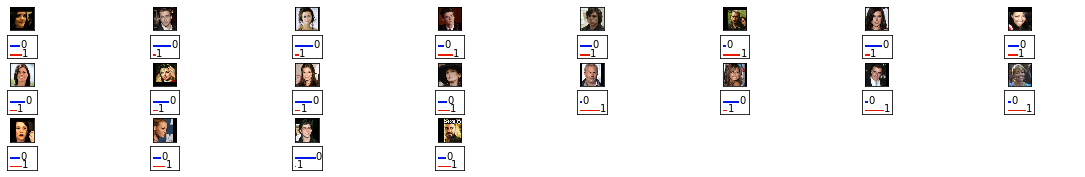

In [21]:
# doing 5th epoch now
loss_record = []
train_net(loss_record, train_num_epochs = 0)

In [22]:
def print_loss(loss_record):
    N = len(loss_record)
    plt.plot(range(N), loss_record, 'ro')
    plt.axis([0, N-1, 0, 1])
    plt.show()

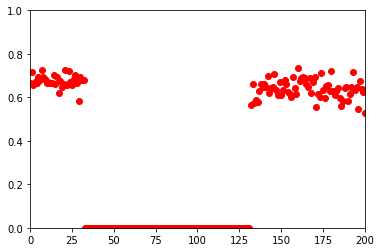

In [93]:
print_loss(new_loss_record) # epochs 1, 5 and 6

In [24]:
import pickle
loss_record = pickle.load(open('loss_record.txt', 'rb'))

In [25]:
len(loss_record)/30

38.5

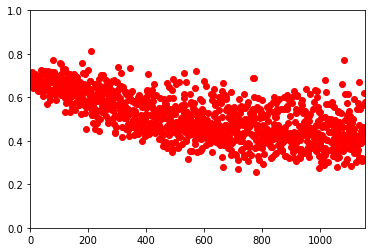

In [27]:
print_loss(loss_record)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

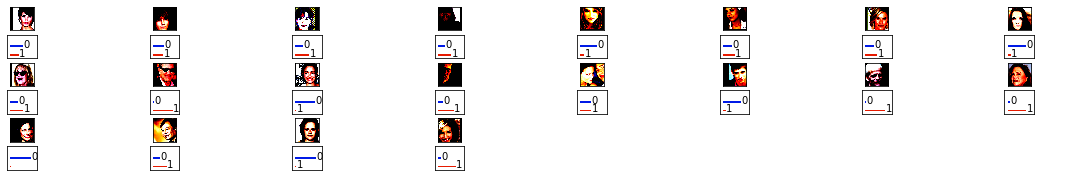

In [28]:
indices = np.random.choice(range(data.num_test_samples), 20)
plotdata(data, indices, net, original=False)

In [36]:
batch_enum = enumerate(data.loader_test)
batch_idx, (testdata, testtargets) = next(batch_enum)
net = net.eval()
out net(testdata)
pred = torch.argmax(net(testdata), dim=1)

net = net.train()
eq = pred == testtargets

t = [] # true, the prediction matches what was expected
f = [] # false
for i, res in enumerate(eq):
    if res == True:
        t.append(i)
    else:
        f.append(i)

print(len(t)/len(testtargets))

0.808


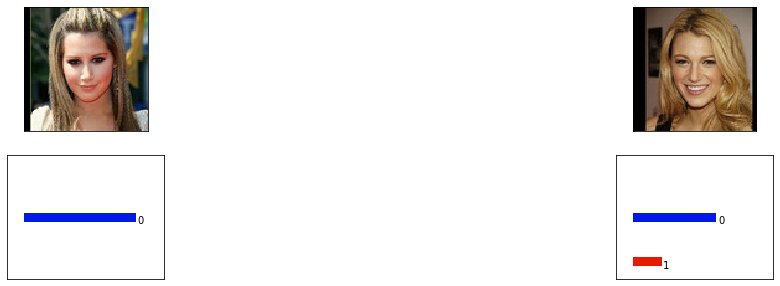

In [52]:
t = np.array(t)
f = np.array(f)
plotdata(data, f[18:20], net, original=True)